In [1]:
import numpy as np
import pandas as pd

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#Plotly and Cufflinks
import cufflinks as cf #importing plotly and cufflinks in offline mode  
import plotly.offline  
cf.go_offline()  
cf.set_config_file(offline=False, world_readable=True)


from IPython.display import Image

pd.options.display.max_rows=20

import spacy
import en_core_web_sm

#Scikit-learn libraries 

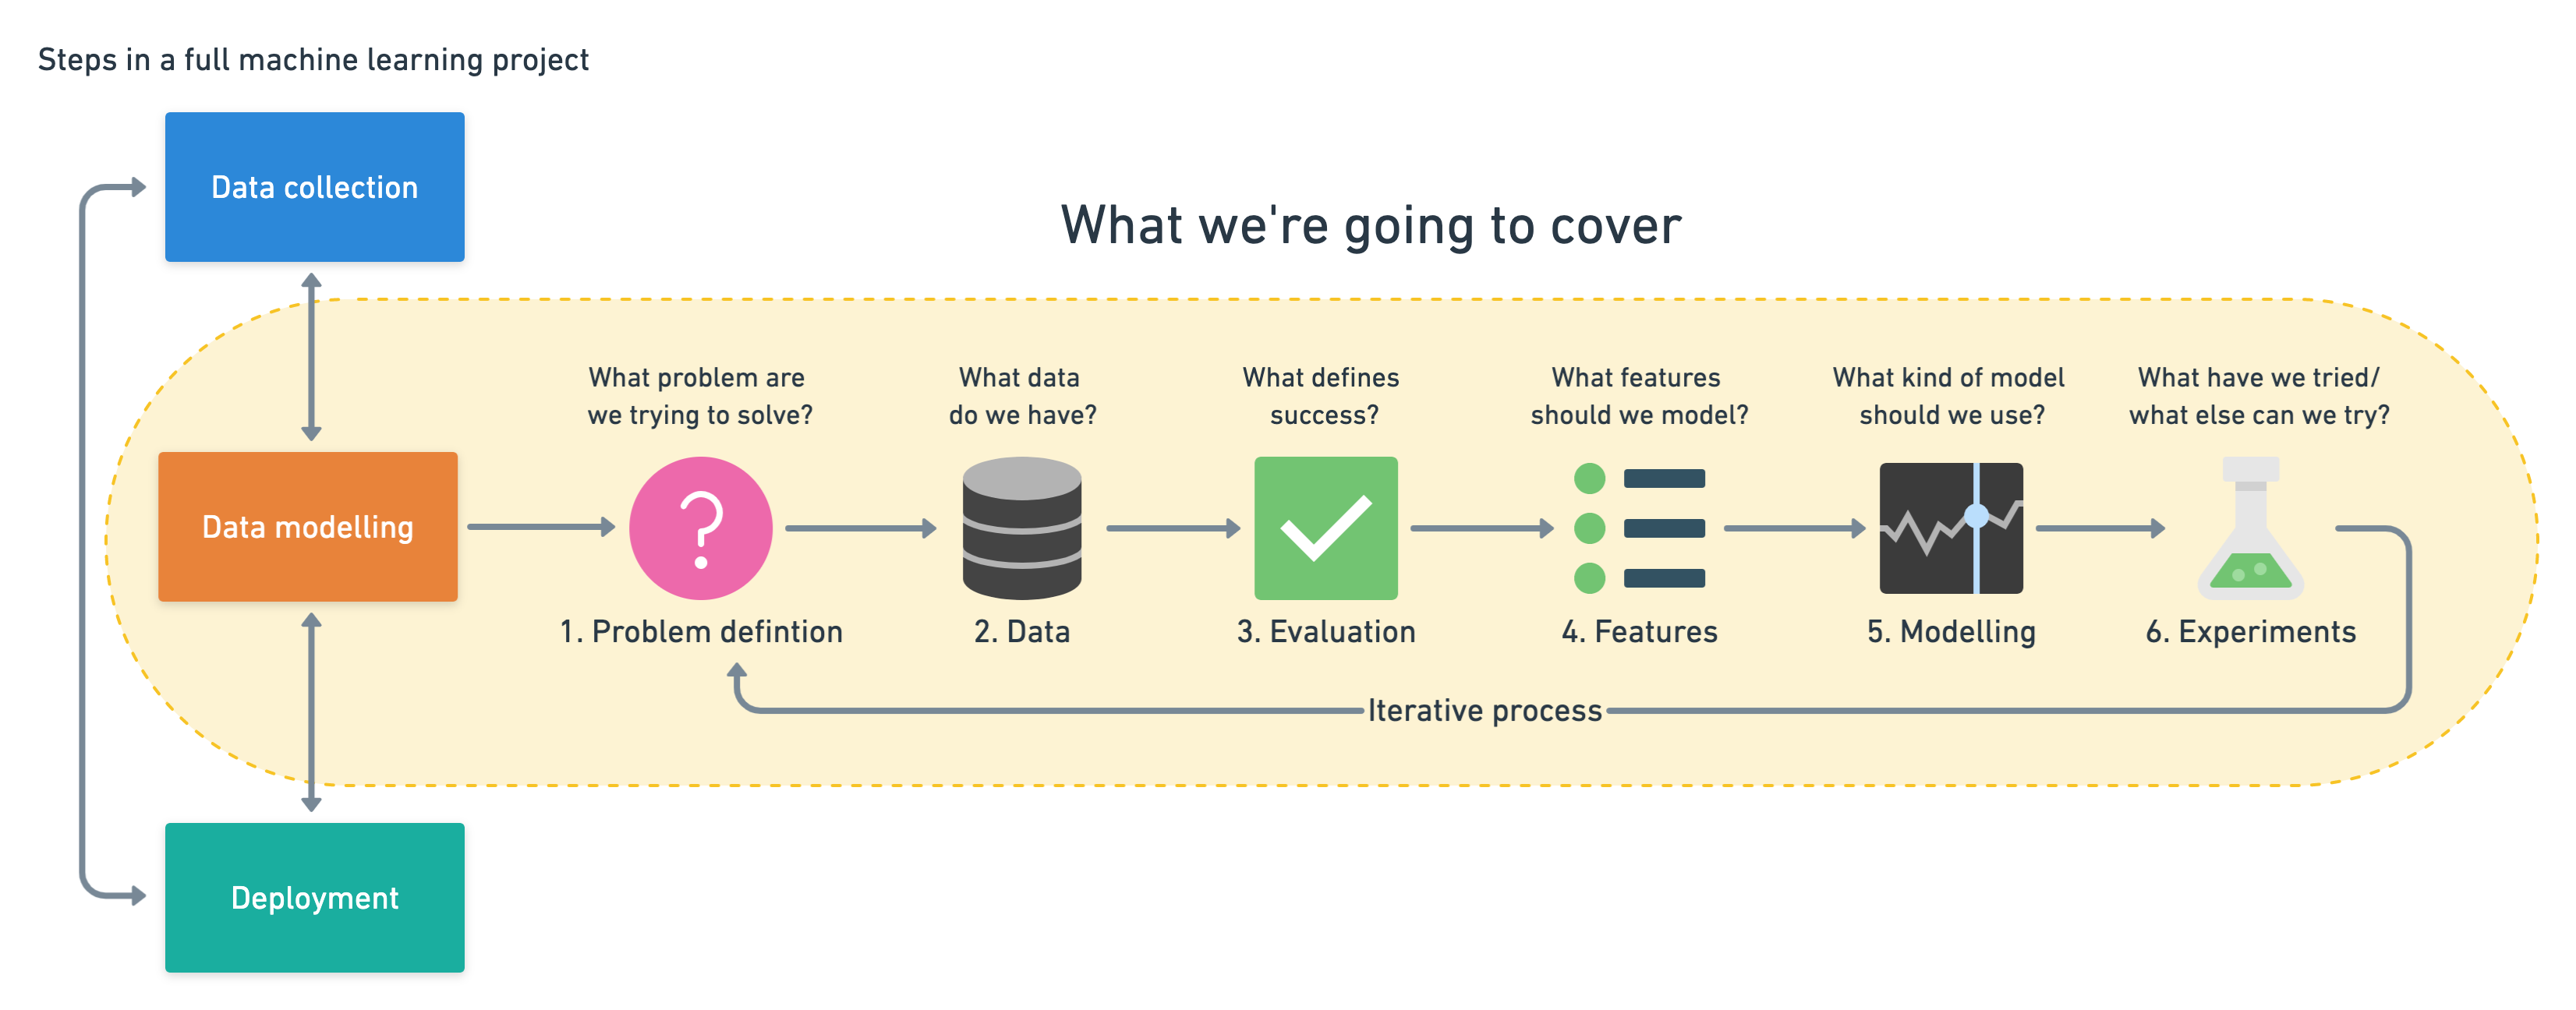

In [2]:
Image(filename='ml101-6-step-ml-framework.png')

project1- Tweet Sentiment Extraction

My ridiculous dog is amazing." [sentiment: positive]

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description?

In this project i will be working with what words in tweets support a positive, negative, or neutral sentiment?

OBJECTIVE: Your objective is to construct a model that can do the same - look at the labeled sentiment for a given tweet and figure out what word or phrase best supports it. https://www.kaggle.com/c/tweet-sentiment-extraction/overview

In [1]:
import os
for dirname, _, filenames in os.walk('/Tweet-Sentiment-Extraction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
#READ THE DATA
tweet_train = pd.read_csv("train.csv")
tweet_test = pd.read_csv("test.csv")

In [4]:
tweet_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
tweet_train.describe(include = 'all')

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,8af8378d17,contemplating when to hand in my lovely car,good,neutral
freq,1,1,199,11118


In [6]:
tweet_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
tweet_train.dropna(inplace=True) # Drop the missing data

In [8]:
tweet_train.columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

In [9]:
tweet_train.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            27471, 27472, 27473, 27474, 27475, 27476, 27477, 27478, 27479,
            27480],
           dtype='int64', length=27480)

In [10]:
print(tweet_train.shape)
print(tweet_test.shape)

(27480, 4)
(3534, 3)


#PANDAS PROFILING 

Generates profile reports from a pandas DataFrame.

The pandas df.describe() function is great but a little basic for serious exploratory data analysis. pandas_profiling extends the pandas DataFrame with df.profile_report() for quick data analysis.

For each column the following statistics - if relevant for the column type - are presented in an interactive HTML report:

Type inference: detect the types of columns in a dataframe.
Essentials: type, unique values, missing values
Quantile statistics like minimum value, Q1, median, Q3, maximum, range, interquartile range
Descriptive statistics like mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness
Most frequent values
Histogram
Correlations highlighting of highly correlated variables, Spearman, Pearson and Kendall matrices
Missing values matrix, count, heatmap and dendrogram of missing values
Text analysis learn about categories (Uppercase, Space), scripts (Latin, Cyrillic) and blocks (ASCII) of text data.
File and Image analysis extract file sizes, creation dates and dimensions and scan for truncated images or those containing EXIF information.

In [11]:
from pandas_profiling import ProfileReport
profile = ProfileReport(tweet_train, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

<AxesSubplot:xlabel='sentiment', ylabel='count'>

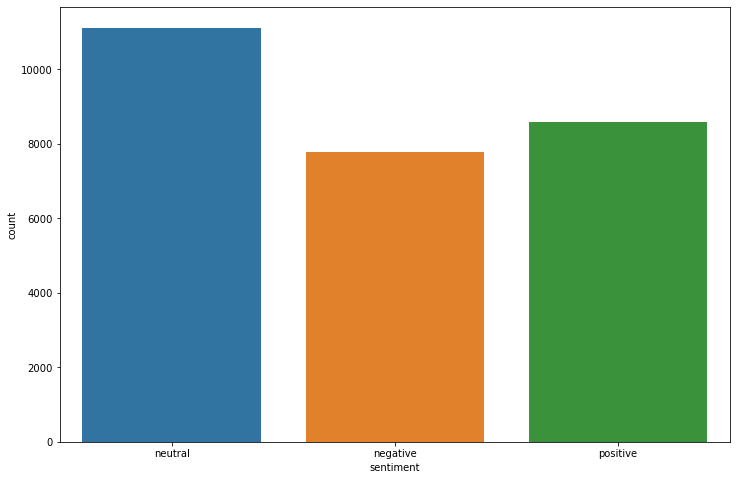

In [12]:
#Visualize the sentinment counts
plt.figure(figsize =(12,8))
sns.countplot(x='sentiment', data = tweet_train)

In [13]:
tweet_train.sentiment.value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [14]:
positive_sentiment = tweet_train[tweet_train.sentiment == 'positive']
negative_sentiment = tweet_train[tweet_train.sentiment == 'negative']
neutral_sentiment = tweet_train[tweet_train.sentiment == 'neutral']

# Generating Meta-Features
In this notebook,I used Number of words in selected text and main text ,Length of words in text and selected as main meta features,but in the context of this competition where we have to predict selected_text which is a subset of text, more useful features to generate would be :-

Difference In Number Of words of Selected_text and Text
Jaccard Similarity Scores between text and Selected_text
Thus it will not be useful for us to generate features we used before as they are of no importance here

For what who don't know what Jaccard Similarity is : https://www.geeksforgeeks.org/find-the-jaccard-index-and-jaccard-distance-between-the-two-given-sets/

In [15]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return len(c) / (len(a) + len(b) - len(c))

In [16]:
results_jaccard=[]

for ind,row in tweet_train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [17]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
tweet_train = tweet_train.merge(jaccard,how='outer')

In [18]:
tweet_train['Num_words_ST'] = tweet_train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
tweet_train['Num_word_text'] = tweet_train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
tweet_train['difference_in_words'] = tweet_train['Num_word_text'] - tweet_train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [19]:
tweet_train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


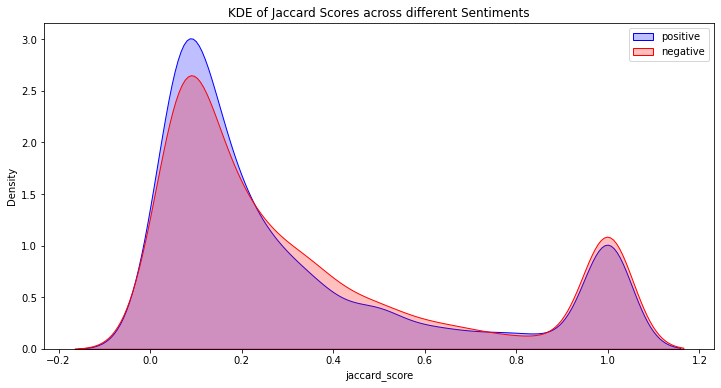

In [20]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(tweet_train[tweet_train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(tweet_train[tweet_train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

# Conclusion Of EDA¶
We can see from the jaccard score plot that there is peak for negative and positive plot around score of 1 .That means there is a cluster of tweets where there is a high similarity between text and selected texts ,if we can find those clusters then we can predict text for selected texts for those tweets irrespective of segment


In [21]:
nlp = en_core_web_sm.load()

In [22]:
doc = nlp(str(tweet_train.text))

In [23]:
for token in doc:
    print(f'{token.text:{15}} {token.pos_:}')

0               PUNCT
                      SPACE
I`d             PROPN
have            AUX
responded       VERB
,               PUNCT
if              SCONJ
I               PRON
were            AUX
going           VERB

               SPACE
1               NUM
                SPACE
Sooo            PROPN
SAD             PROPN
I               PRON
will            AUX
miss            VERB
you             PRON
here            ADV
in              ADP
San             PROPN
Diego           PROPN
!               PUNCT
!               PUNCT
!               PUNCT

               SPACE
2               NUM
                                SPACE
my              PRON
boss            NOUN
is              AUX
bullying        VERB
me              PRON
...             PUNCT

               SPACE
3               NUM
                           SPACE
what            PRON
interview       NOUN
!               PUNCT
leave           VERB
me              PRON
alone           ADJ

               SPACE
4          

# VISUALIZATION

In [24]:
from spacy import displacy

In [25]:
displacy.render(doc, style = 'dep', options = {'distance': 100, 'compact': True})

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer